<a href="https://colab.research.google.com/github/soumibasu0193/Course-Certified-Solutions-Architect-Associate/blob/master/Optimization_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries and Data

In [ ]:
#!pip install gurobipy
import gurobipy as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read in the data and set the timespot below.

In [ ]:
stocks_2019 = pd.read_csv('stocks2019.csv')
stocks_2020 = pd.read_csv('stocks2020.csv')
timestop = 3600

### Create Returns DataFrame

In [ ]:
returns_df = pd.DataFrame()

for stock in stocks_2019.columns[2:]:
    returns_df[stock] = (stocks_2019[stock]) / (stocks_2019[stock].shift()) - 1

returns_df = returns_df.dropna().reset_index().drop('index', axis = 1)

### Part 1
### Pick Stocks
Start with m=5. Find the best 5 stocks to include in your portfolio and the weights of those 5
stocks, using the 2019 data.

In [ ]:
def pick_stocks(m, p, returns):
    
    num_stocks = len(p)
    obj = np.array(p.values.flatten().tolist() + [0] * num_stocks)
    A = np.zeros(((num_stocks ** 2 + num_stocks + 1), (num_stocks ** 2 + num_stocks)))
    b = np.zeros(num_stocks ** 2 + num_stocks + 1)
    direction = np.array([''] * len(b))

    
    # Constraint 1
    A[0,-len(p):] = [1] * (num_stocks)
    b[0] = m
    direction[0] = '='


    # Constraint 2
    ind_vec = np.array(range(num_stocks))
    row = 1
    for j in range(num_stocks):
        A[row,j*num_stocks + ind_vec] = 1
        b[row] = 1
        direction[row] = '='
        row+=1
        
        
    # Constraint 3
    counter = 0
    while row != A.shape[0]:
        for i in range(num_stocks):
            A[row, [(i * len(p) % len(p)**2) + counter, counter + len(p)**2]] = [1, -1]
            b[row] = 0
            direction[row] = '<'
            row += 1
        counter += 1

    # c1,c2,c3,c4,y1,y2
    #  1  0  0  0  -1 0
    #  0  0  1  0  -1 0 
    #  0  1  0  0  0  -1
    #  0  0  0  1  0  -1
    
    # xij <= yj
    # b = 0
    
    Model = gp.Model()
    Mod_x = Model.addMVar(len(obj), vtype = 'B')
    Mod_con = Model.addMConstrs(A, Mod_x, direction, b) 
    Model.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)
    Model.Params.OutputFlag = 0 
    Model.optimize()
    x = Model.x
    temp_df = pd.DataFrame(x)
    stocks = temp_df[(temp_df[0] == 1) & (temp_df.index >= (num_stocks ** 2))].index.values - num_stocks**2
    
    selected_stocks = returns.iloc[:,stocks]
    return selected_stocks

In [ ]:
p = returns_df.corr()
m = 5
stocks = pick_stocks(m, p, returns_df)

### Obtain Weights

In [ ]:
def get_weights(x, data):
    obj = np.array([0] * x.shape[1] + [1] * x.shape[0])
    
    A = np.zeros((2*x.shape[0] + 1, len(obj)))
    b = np.zeros(2*x.shape[0] + 1)
    direction = np.array([''] * (2*x.shape[0] + 1))
    
    # Constraint 1
    # weights must add up to one
    A[0,:x.shape[1]] = 1
    b[0] = 1
    direction[0] = '='
    

    row = 1
    # Constraint 2
    # get the returns of each stock for each day and set the difference to 1
    for i in range(len(x)):
        A[row, :x.shape[1]] = x.iloc[row - 1].tolist()
        A[row, i+x.shape[1]] = 1
        b[row] = data.iloc[row - 1, 0].tolist()
        direction[row] = '>'
        row += 1
    
        # y1  y2  d1  d2
# day 1  ry1 ry2  1   0 
# day 2  ry1 ry2  0   1

# b[0] <- corresponds to day1 = return of the index on day 1
    
    # Constraint 3
    for i in range(len(x)): 
        return_vals = (x.iloc[row - (x.shape[0] + 1)].values) * -1
        A[row, :x.shape[1]] = return_vals.tolist()
        A[row, i+x.shape[1]] = 1
        index_vals = (data.iloc[row - (x.shape[0] + 1), 0]) * -1
        b[row] = index_vals.tolist()
        direction[row] = '>'
        row += 1
    
         # y1  y2  d1  d2
# day 1  -ry1 -ry2  1   0 
# day 2  -ry1 -ry2  0   1

# b[0] <- corresponds to day1 = negative return of the index on day 1
    
    Model = gp.Model()
    Mod_x = Model.addMVar(len(obj))
    Mod_con = Model.addMConstrs(A, Mod_x, direction, b) 
    Model.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)
    Model.Params.OutputFlag = 0 
    Model.optimize()
    return Model.x[:x.shape[1]]
    

### Part 3
### Calculate Tracking to the Index
This calculates difference in tracking returns with the weights we got for 2019 (apply these weights onto stocks in 2020 and compare to 2020 index) compared to 2020 index


In [ ]:
def calculate_tracking(weights, data):

    difference = 0
    for t in range(len(data)):
        day_return = 0
        for s in range(len(weights)):
            day_return += data.iloc[t,s+1] * weights[s]
        difference += abs(data.iloc[t,0] - day_return)
    return difference

In [ ]:
returns_df_ndx_2020 = pd.DataFrame()

for stock in stocks_2020.columns[1:]:
    returns_df_ndx_2020[stock] = (stocks_2020[stock]) / (stocks_2020[stock].shift()) - 1

returns_df_ndx_2020 = returns_df_ndx_2020.dropna().reset_index().drop('index', axis = 1)

returns_df_ndx = pd.DataFrame()

for stock in stocks_2019.columns[1:]:
    returns_df_ndx[stock] = (stocks_2019[stock]) / (stocks_2019[stock].shift()) - 1

returns_df_ndx = returns_df_ndx.dropna().reset_index().drop('index', axis = 1)
#returns_df_ndx_2020_copy_1 = returns_df_ndx_2020[['NDX'] + stocks.columns.values.tolist()]
#returns_df_ndx_copy_1 = returns_df_ndx[['NDX'] + stocks.columns.values.tolist()]

### Cumulative Function to Get Performance

In [ ]:
def get_entire_performance(m_list, p, data1, data2, data3, problem = 'IP', weight_list = [], return_stocks = 'Y'):
    performance_df = pd.DataFrame()
    
    if problem == 'MIP':
        m = m_list
        tracking_difference = calculate_tracking(weight_list, data3)
        performance_df["M " + str(m)] = [tracking_difference]
        return performance_df
    else:
        m = m_list
        stocks = pick_stocks(m, p, data1)
        if return_stocks == 'Y':
            return stocks
        weights = get_weights(stocks, data2)
        tracking_difference = calculate_tracking(weights, data3)
        performance_df["M " + str(m)] = [tracking_difference]
        return performance_df

In [ ]:
weights = get_weights(stocks, returns_df_ndx)
weights

In [ ]:
f_track_2020 = pd.DataFrame()
f_track_2019 = pd.DataFrame()

for m in range(10,stocks_2020.shape[1], 10):
    stock_2019 = get_entire_performance(m, p, returns_df, returns_df_ndx, returns_df_ndx, return_stocks = 'Y')
    returns_df_ndx_copy = returns_df_ndx[['NDX'] + stock_2019.columns.values.tolist()]
    weights_copy = get_weights(stock_2019, returns_df_ndx_copy)
    
    returns_df_ndx_2020_copy = returns_df_ndx_2020[['NDX'] + stock_2019.columns.values.tolist()]

    tracking_2019_copy = calculate_tracking(weights_copy, returns_df_ndx_copy)
    tracking_2020_copy = calculate_tracking(weights_copy, returns_df_ndx_2020_copy)
    

    f_track_2020["M " + str(m)] = [tracking_2020_copy]
    f_track_2019["M " + str(m)] = [tracking_2019_copy]

### Part 4
### MIP Optimization

In [ ]:
def optimize_portfolio(m, p, returns_df, timestop, index_returns):

    M = 1
    data = pick_stocks(returns_df.shape[1], p, returns_df)
    obj = np.array([0] * data.shape[1] + [1] * data.shape[0] + [0] * data.shape[1])
    A = np.zeros((2*data.shape[0] + 1 + data.shape[1] + 1, len(obj)))
    b = np.zeros(2*data.shape[0] + 1 + data.shape[1] + 1)
    direction = np.array([''] * (2 * data.shape[0] + 1 + data.shape[1] + 1))
    
    
    # Constraint 1
    A[0,:data.shape[1]] = 1
    b[0] = 1
    direction[0] = '='
    
    
    row = 1
    # Constraint 2
    for i in range(len(data)):
        A[row, :data.shape[1]] = data.iloc[row - 1].tolist()
        A[row, i+data.shape[1]] = 1
        b[row] = index_returns.iloc[row - 1, 0].tolist()
        direction[row] = '>'
        row += 1
    
    
    # Constraint 3
    for i in range(len(data)): 
        return_vals = (data.iloc[row - (data.shape[0] + 1)].values) * -1
        A[row, :data.shape[1]] = return_vals.tolist()
        A[row, i+data.shape[1]] = 1
        index_vals = (index_returns.iloc[row - (data.shape[0] + 1), 0]) * -1
        b[row] = index_vals.tolist()
        direction[row] = '>'
        row += 1
        
        
    # Constraint 4
    for w in range(returns_df.shape[1]):
        A[row, [w, w + data.shape[0] + data.shape[1]]] = [1, -M]
        b[row] = 0 
        direction[row] = '<'
        row += 1

    
    # Constraint 5
    A[row, -len(p):] = 1
    b[row] = m
    direction[row] = '='
    
    vtype = ['C'] * (data.shape[1] + data.shape[0]) + ['B'] * data.shape[1]
    Model = gp.Model()
    Mod_x = Model.addMVar(len(obj), vtype = vtype)
    Mod_con = Model.addMConstrs(A, Mod_x, direction, b) 
    Model.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE)

    Model.Params.OutputFlag = 0 
    Model.Params.TimeLimit = timestop

    print("Optimizing for m = {0}".format(m))

    Model.optimize()
    weights = np.array(Model.x[:returns_df.shape[1]])
    return weights, Model.x
    

In [ ]:
#############################
##### 10 Hour Program #######
#############################
temp_df = pd.DataFrame(columns = returns_df.columns.values)
model_x_list = []
for m in range(10, stocks_2020.shape[1], 10):
    weights, model_x = optimize_portfolio(m, p, returns_df, timestop, returns_df_ndx)
    temp_df.loc[m, :] = weights
    temp_df.to_csv('m' + str(m) + ".csv")
    model_x_list.append(model_x)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  import sys


Optimizing for m = 10
Optimizing for m = 20
Optimizing for m = 30
Optimizing for m = 40
Optimizing for m = 50
Optimizing for m = 60
Optimizing for m = 70
Optimizing for m = 80
Optimizing for m = 90
Optimizing for m = 100


In [ ]:
#temp_df = pd.read_csv('m100.csv') ### Only necessary when you don't want to wait for the full step above

In [ ]:
data3 = pd.DataFrame()

for stock in stocks_2020.columns[1:]:
    data3[stock] = (stocks_2020[stock]) / (stocks_2020[stock].shift()) - 1

data3 = data3.dropna().reset_index().drop('index', axis = 1)
final_tracking_2020 = pd.DataFrame()
final_tracking_2019 = pd.DataFrame()

for row in temp_df.index:
    weight_list = temp_df.loc[row, :].to_list()
    data3_copy = data3[['NDX'] + temp_df.columns.values.tolist()]

    tracking = get_entire_performance(row, p, returns_df, returns_df_ndx, data3_copy, problem = 'MIP', weight_list = weight_list)
    tracking_2019 = get_entire_performance(row, p, returns_df, returns_df_ndx, returns_df_ndx, problem = 'MIP', weight_list = weight_list)
    
    final_tracking_2020['M ' + str(row)] = tracking['M ' + str(row)]
    final_tracking_2019['M ' + str(row)] = tracking_2019['M ' + str(row)]
    

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


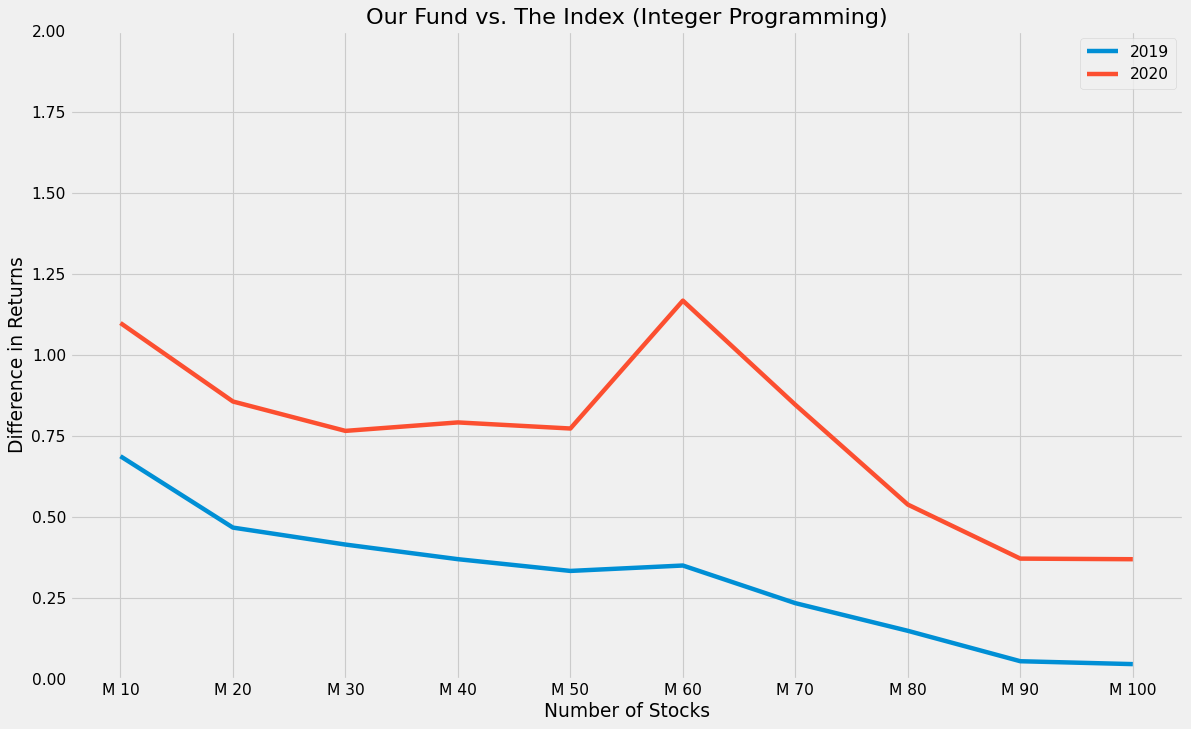

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,10), dpi=80)
plt.plot(f_track_2019.columns, f_track_2019.iloc[0,:],label='2019')
plt.plot(f_track_2020.columns, f_track_2020.iloc[0,:],label='2020')
plt.title('Our Fund vs. The Index (Integer Programming)')
plt.xlabel('Number of Stocks')
plt.ylabel('Difference in Returns')
plt.ylim(0, 2)
plt.legend()
plt.savefig('integer')
plt.show()

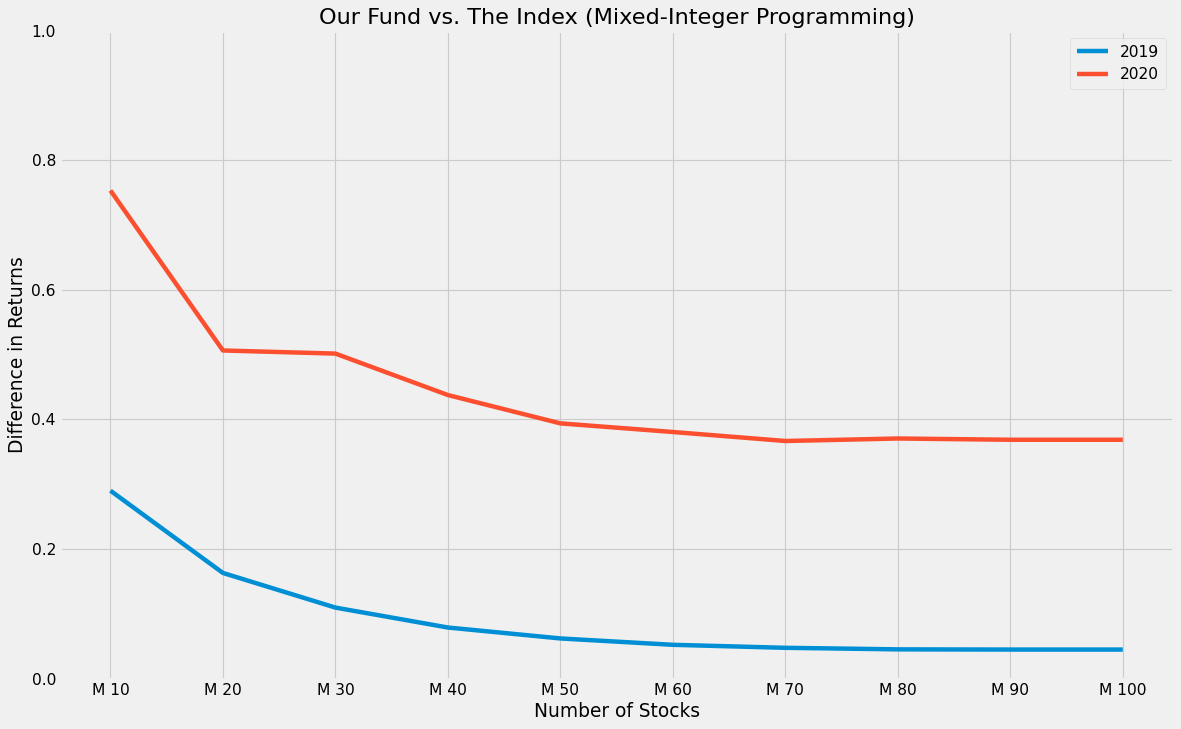

In [ ]:
plt.figure(figsize=(16,10), dpi=80)
plt.plot(final_tracking_2019.columns, final_tracking_2019.iloc[0,:],label='2019')
plt.plot(final_tracking_2020.columns, final_tracking_2020.iloc[0,:],label='2020')
plt.title('Our Fund vs. The Index (Mixed-Integer Programming)')
plt.xlabel('Number of Stocks')
plt.ylabel('Difference in Returns')
plt.ylim(0, 1)
plt.legend()
plt.savefig('mix')
plt.show()
